In [1]:
import ephem
import math
from datetime import datetime, timedelta, timezone
import argparse
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simpson
from astropy.cosmology import FlatLambdaCDM, z_at_value
import matplotlib as mpl
from matplotlib.colors import LogNorm
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km/u.s/u.Mpc, Om0=0.3)


mpl.rcParams.update({
    'text.usetex':     False,
    'mathtext.fontset':'cm',                
    'font.family':     'serif',
    'font.serif':      ['DejaVu Serif'],    
    'font.size':       12,
    'axes.labelsize':  14,
})

# Flaring Blazar Expectations

Here we use the case of TXS 0506 as a case study. We use as a benchmark flux the one presented in Fig 4 of Ref. 1. The flux is chosen because it resembles the shape of the neutrino spectrum and is normalized to the measured IceCube data for the 2014-2015 flare.

The function observable_time calculates how much time the telescope is able to observe a source following the conditions:

1. The sun's altitude must be below 15 degrees.
2. The source must have an altitude between -15 and 0 degrees.
3. The moon phase must be less than 90\%.
4. The moon's altitude is less than -2 degrees OR the moon is located at least 30 degrees in azimuth apart form the source. 

In [2]:
# NEW: small helpers for azimuth wrap-safe separation
def _wrap_deg(x): 
    return x % 360.0

def _angsep_az(a_deg, b_deg):
    d = abs(_wrap_deg(a_deg) - _wrap_deg(b_deg))
    return min(d, 360.0 - d)

def observable_time(latitude = 38.5202, longitude = -113.2883, elevation = 3048, start_date = '2024/04/11', end_date = '2025/04/11', ras = "02:42:40.7091669408", decl = "-00:00:47.859690204", cumulative = False):    
    # Set up command-line arguments.
    args = type("Args", (), {})()  # Create an empty object.
    args.ra = ras
    args.dec = decl
    args.sdate = str(start_date)
    args.edate = str(end_date)
    args.lat = str(latitude)
    args.lon = str(longitude)
    args.elev = int(elevation)
    
    # Create an Observer and set its location and starting time.
    obs = ephem.Observer()
    obs.lat = args.lat
    obs.lon = args.lon
    obs.elev = args.elev
    obs.date = args.sdate
    
    # Create the target source using RA and Dec.
    source = ephem.FixedBody()
    source._ra = ephem.hours(args.ra)
    source._dec = ephem.degrees(args.dec)
    source.compute(obs)
    
    # Get simulation start time as a datetime object.
    sim_start = obs.date.datetime()
    current_time = sim_start
    sim_end = ephem.Date(end_date).datetime()
    
    # Define simulation parameters.
    time_diff = sim_end - sim_start
    simulation_minutes = time_diff.total_seconds()/60  
    time_step = timedelta(minutes=1)
    observable_minutes = 0
       
    #arrays to store data
    times = [sim_start + timedelta(minutes=i) for i in range(int(simulation_minutes))]
    sun_elev = []
    moon_elev = []
    source_elev = []
    moon_phase = []
    conditions = []

    # containers for daily aggregation
    daily_minutes = {}  # {date: minutes_that_day}

    # NEW: your horizontal field of view (deg) and derived exclusion half-width
    FOV_AZ_DEG = 60.0
    EXCL_HALF_DEG = FOV_AZ_DEG / 2.0  # = 30°
    
    # Simulation loop: iterate in one-minute steps.
    while current_time < sim_end:
        obs.date = current_time
            
        # Update positions of the source, Sun, and Moon.
        source.compute(obs)
        sun = ephem.Sun();  sun.compute(obs)
        moon = ephem.Moon(); moon.compute(obs)
    
        # Convert altitudes (radians) to degrees.
        sun_alt_deg    = math.degrees(sun.alt)
        source_alt_deg = math.degrees(source.alt)
        moon_alt_deg   = math.degrees(moon.alt)
        moonphase      = moon.phase

        # NEW: azimuths in degrees
        source_az_deg  = math.degrees(source.az)
        moon_az_deg    = math.degrees(moon.az)
    
        #filling arrays for plotting
        sun_elev.append(sun_alt_deg)
        moon_elev.append(moon_alt_deg)
        source_elev.append(source_alt_deg)
        moon_phase.append(moonphase)
    
        #getting last setting and rising times for moon (kept; unused now)
        last_rise_moon = obs.previous_rising(moon)
        last_set_moon  = obs.previous_setting(moon)
        
        # Check conditions:
        # 1. The Sun's altitude must be below -15°.
        conditions_met = (sun_alt_deg < -15)
        
        # 2. The source must have an altitude between -15° and 0°.
        conditions_met = conditions_met and (-15 < source_alt_deg < 0)
    
        # 3. The Moon's phase must be less than 90%.
        conditions_met = conditions_met and (moonphase < 90)

        # 4. Moon altitude and azimuth exclusion relative to where you must point
        if moon_alt_deg < -2:
            # Moon is low enough — OK regardless of azimuth
            conditions_met = conditions_met and True
            conditions.append(conditions_met)
        else:
            # require the Moon to be outside the forward azimuth sector around the source
            az_clear = (_angsep_az(source_az_deg, moon_az_deg) > EXCL_HALF_DEG)
            conditions_met = conditions_met and az_clear
            conditions.append(conditions_met)
    
        # If all conditions are met, count this minute as observable.
        if conditions_met:
            observable_minutes += 1

            # track minutes per (UTC) date
            day_key = current_time.date()
            daily_minutes[day_key] = daily_minutes.get(day_key, 0) + 1
    
        # Increment the current time by one minute.
        current_time += time_step
    
    # Convert total observable minutes to hours and output the result.
    total_hours = observable_minutes / 60.0
    print("Total observable time for source (RA: {}, Dec: {}) from {} to {} is {:.2f} hours."
            .format(args.ra, args.dec, args.sdate, args.edate, total_hours))

    # if cumulative series requested, build and return it
    if cumulative:
        first_day = sim_start.date()
        last_day = (sim_end - timedelta(minutes=1)).date()
        daily_cumulative_minutes = []
        daily_cumulative_hours = []
        running = 0
        d = first_day
        while d <= last_day:
            day_min = daily_minutes.get(d, 0)
            running += day_min
            daily_cumulative_minutes.append((d.isoformat(), running))
            daily_cumulative_hours.append((d.isoformat(), running/60.0))
            d += timedelta(days=1)
        return daily_cumulative_minutes, daily_cumulative_hours

def expected_neutrino(fluence,Aeff,E):
    dNdE =  fluence*E**(-2)
    y = dNdE*Aeff
    # I want to integrate in log space in order to get a better estimate
    return simpson(y*E,x = np.log(E))

def event_number(T,dL,cum_hours):
    # Source distance scaling
    dL0 = 1774                    # Mpc
    dLnew = dL                  # Mpc
    pc2cm = 3.086e18             # 1 parsec in cm
    erg2gev = 624.2              # 1 erg in GeV
    
    dL0_cm   = dL0 * 1e6 * pc2cm
    dLnew_cm = dLnew * 1e6 * pc2cm
    z0 =  z_at_value(cosmo.luminosity_distance, dL0_cm * u.cm)
    znew = z_at_value(cosmo.luminosity_distance, dLnew_cm * u.cm)

    energies = np.array([1e6, 1e7, 1e8, 1e9, 1e10])*1e9
    Tobs = cum_hours[T-1][1] #hours
    Tobs = Tobs*60*60 #seconds
    
    # scale flux 
    
    
    dL_factor = (dL0**2/(dLnew)**2)
    flux_vals = dL_factor * erg2gev * txs_sed[:,1] * 1e9
    fluence_vals = Tobs*flux_vals
    flu_interp = interp1d(txs_sed[:,0], fluence_vals, fill_value='extrapolate')
    fluence_E   = flu_interp(energies)/3    # array of length 5 divide by 3 to account for tau only
    for i in range(len(fluence_E)):   #if a value is less than zero due to the extrapolation we make it equal to zero
        if fluence_E[i]<0 : 
            fluence_E[i] = 0     
    N = expected_neutrino(fluence_E,Aeff[:,1],energies)
    return N

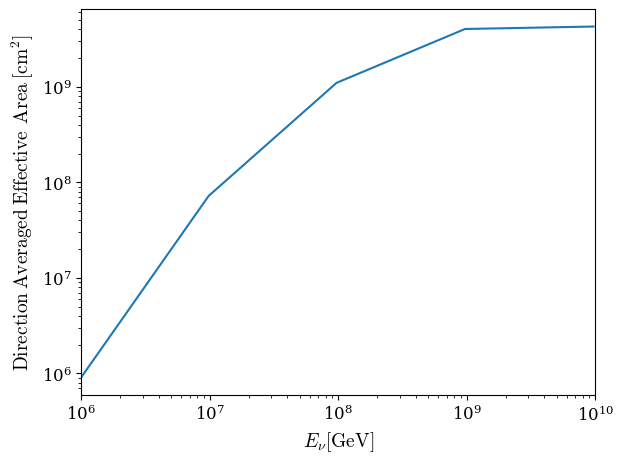

In [3]:
# Here I will make a plot of flaring time vs luminosity distance 
Aeff = np.array([
    [999362.9705021202, 916117.101533752],
    [9775707.237408124, 72001979.23553275],
    [96726901.36251712, 1098435598.0092568],
    [967824721.9304067, 4023768215.8895645],
    [9699897500.859245, 4270186612.458323]
]) # direction averaged effective area cm^2

plt.loglog(Aeff[:,0],Aeff[:,1])
plt.xlabel(r'$E_\nu \rm{[GeV]}$')
plt.ylabel(r'$\rm{Direction\: Averaged\: Effective\:\:Area}\:[\rm{cm}^2]$')
plt.xlim([1e6,1e10])
plt.tight_layout()
plt.show()

Text(0, 0.5, '$E_\\nu \\phi_\\nu  [\\rm{erg\\:cm}^{-2} \\: \\rm{s}^{-1}]$')

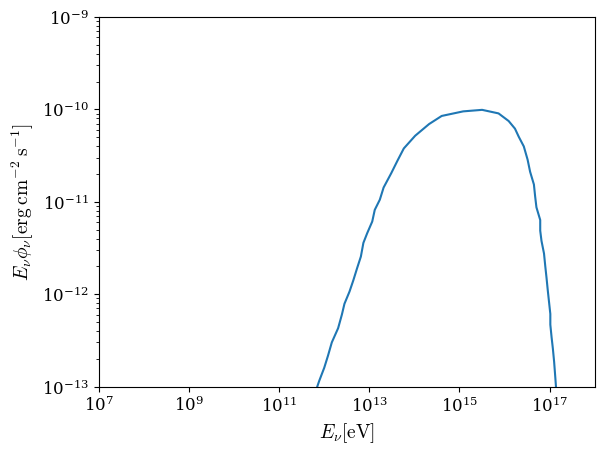

In [4]:
txs_sed = np.genfromtxt('files/TXS_FLARE_GOOD.csv', delimiter =',') # eV, erg cm-2 s-1 from ref. 1. 

plt.loglog(txs_sed[:,0],txs_sed[:,1])
plt.xlim([1e7,1e18])
plt.ylim([1e-13,1e-9])
plt.xlabel(r'$E_\nu [\rm{eV}]$')
plt.ylabel(r'$E_\nu \phi_\nu  [\rm{erg\:cm}^{-2} \: \rm{s}^{-1}]$')

In [5]:
%%time 

cumulative_minutes, cumulative_hours = observable_time(start_date = '2014/10/08', end_date = '2015/10/09', ras = '05:09:25.9645434784', decl = '05:41:35.333636817', cumulative=True)

Total observable time for source (RA: 05:09:25.9645434784, Dec: 05:41:35.333636817) from 2014/10/08 to 2015/10/09 is 246.35 hours.
CPU times: user 2min 25s, sys: 218 ms, total: 2min 26s
Wall time: 2min 26s


In [6]:
# calculating cummulative time TXS 


# Filling a grid with the values
Tobs = np.linspace(1,365,200) #days
Tobs_int = Tobs.astype(int) # only integer days
dL = np.logspace(2,4,100) #MPc
N = np.zeros((len(Tobs_int),len(dL)))
for i in tqdm(range(len(Tobs_int))):
    for j in range(len(dL)):
        N[i][j] = event_number(Tobs_int[i],dL[j], cumulative_hours)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:56<00:00,  3.56it/s]


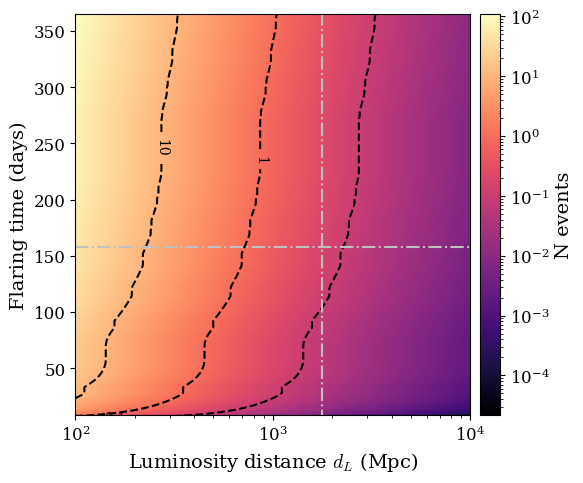

In [9]:
# convert Tobs back to days for plotting

plt.figure(figsize=(6,5))

# the log‐norm colormap
mesh = plt.pcolormesh(
    dL,
    Tobs_int,
    N,
    shading='auto',
    norm=LogNorm(), cmap = 'magma'        # logarithmic color‐scale
)
plt.xscale('log')

# equipotential lines at N = 0.1, 1, 10
levels = [0.1, 1, 10]
cs = plt.contour(
    dL,
    Tobs_int,
    N,
    levels=levels,
    colors='black',
    linewidths=1.5,
    linestyles='--'
)


plt.clabel(cs, fmt='%g', inline=True, fontsize=10, colors='black')
plt.vlines(x =1774,ymin = 1, ymax = 365, ls = '-.', color = 'silver')
plt.hlines(y =158, xmin = 1e2, xmax = 1e4, ls = '-.', color = 'silver')
plt.xlim([1e2,1e4])
plt.ylim([Tobs_int[4],365])
plt.xlabel(r'Luminosity distance $d_L$ (Mpc)')
plt.ylabel(r'Flaring time (days)')

cbar = plt.colorbar(mesh, pad=0.02)
cbar.set_label('N events')

plt.tight_layout()
plt.savefig('outputs/blazar_plot.png')
plt.show()

# References

1. Maria Petropoulou *et al.* (2020). *Multi-Epoch Modeling of TXS 0506+056 and Implications for Long-Term High-Energy Neutrino Emission*. **Astrophys. J. 891, 115**. doi:[10.3847/1538-4357/ab76d0](https://doi.org/10.3847/1538-4357/ab76d0). arXiv:[1911.04010](https://arxiv.org/abs/1911.04010)